# Unsupervised Learning


## To do before...

[Insert here to complete "Concepts" in [Block G](https://darribas.org/gds_course/content/bG/concepts_G.html)]

## Action!

In [1]:
import pandas
from numpy.random import seed

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

orig = pandas.read_csv("../data/paris_abb.csv.zip")
reviews = pandas.read_csv("../data/paris_abb_review.csv.zip")
db = orig.join(reviews.set_index("id"), on="id")

### Explore

In [5]:
review_areas = ["review_scores_accuracy",
                "review_scores_cleanliness",
                "review_scores_checkin",
                "review_scores_communication",
                "review_scores_location",
                "review_scores_value"
               ]

In [6]:
db[review_areas].describe().T

,count,mean,std,min,25%,50%,75%,max
review_scores_accuracy,50280.0,9.576929,0.824413,2.0,9.0,10.0,10.0,10.0
review_scores_cleanliness,50280.0,9.178540,1.107574,2.0,9.0,9.0,10.0,10.0
review_scores_checkin,50280.0,9.660302,0.769064,2.0,10.0,10.0,10.0,10.0
review_scores_communication,50280.0,9.703520,0.727020,2.0,10.0,10.0,10.0,10.0
review_scores_location,50280.0,9.654018,0.696448,2.0,9.0,10.0,10.0,10.0
review_scores_value,50280.0,9.254515,0.930852,2.0,9.0,9.0,10.0,10.0


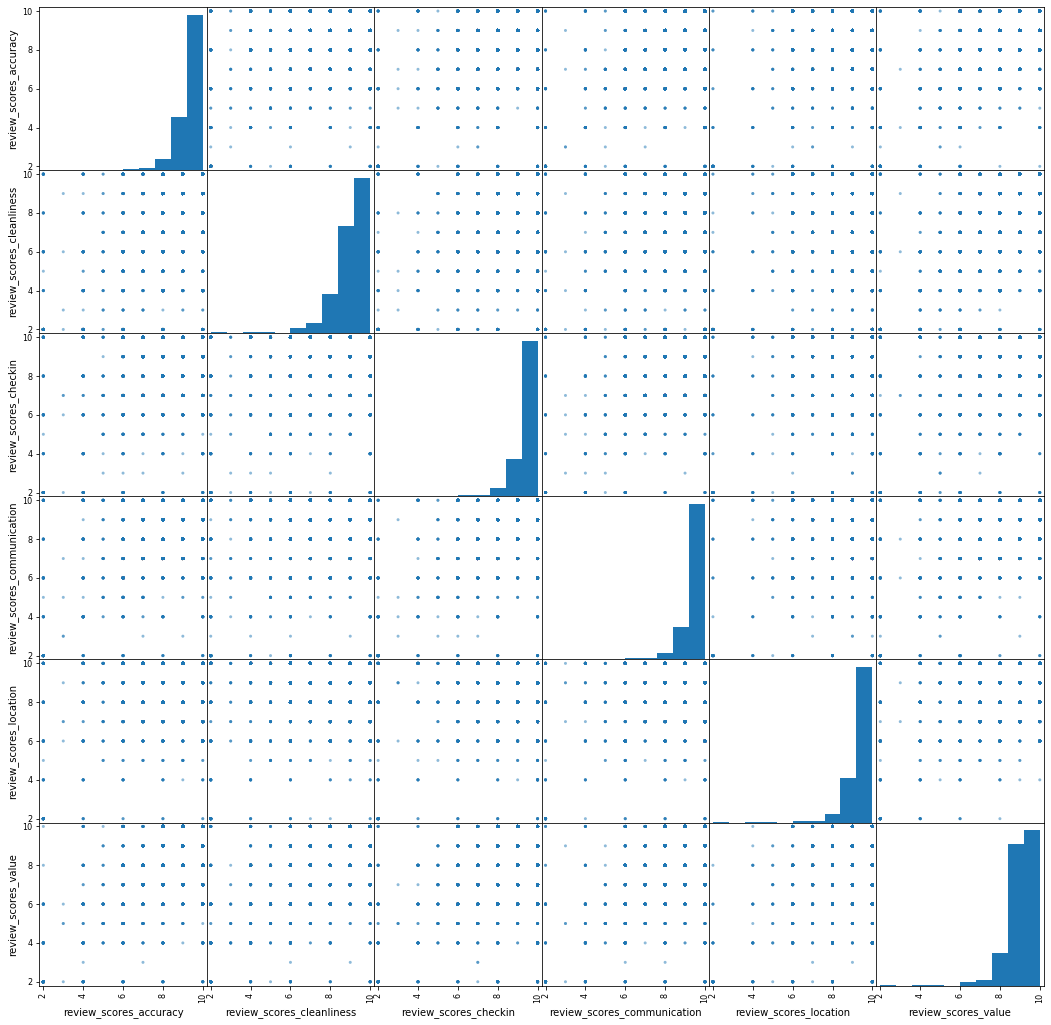

In [7]:
pandas.plotting.scatter_matrix(db[review_areas],
                               figsize=(18, 18));

This 👆, into a composite index.

### Classify

`scikit-learn` has a very consistent API (learn it once, use it across). It comes in a few flavors:

    - `fit`
    - `fit_transform`
    - Direct method

- All raw

In [8]:
estimator = KMeans(n_clusters = 5)
estimator

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
seed(12345)

estimator.fit(db[review_areas])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [10]:
k5_raw = pandas.Series(estimator.labels_,
                       index=db.index
                      )
k5_raw.head()

0    0
1    3
2    0
3    0
4    0
dtype: int32

**NOTE** `fit`

- All standardised

In [11]:
# Minus mean, divided by std
db_stded = scale(db[review_areas])
pandas.DataFrame(db_stded, 
                 index = db.index,
                 columns = review_areas
                ).describe()\
                 .reindex(["mean", "std"])

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
mean,4.748257e-17,2.792427e-16,-1.989746e-16,9.360849e-16,-2.320428e-16,3.764689e-16
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00


**NOTE** `scale` API

In [12]:
# Range scale
range_scaler = MinMaxScaler()
db_scaled = range_scaler.fit_transform(db[review_areas])
pandas.DataFrame(db_scaled,
                 index = db.index,
                 columns = review_areas
                ).describe()\
                 .reindex(["min", "max"])

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


**NOTE** `fit_transform`

In [13]:
seed(12345)

estimator = KMeans(n_clusters = 5)

estimator.fit(db_stded)

k5_std = pandas.Series(estimator.labels_,
                       index=db.index
                      )
k5_std.head()

0    3
1    2
2    3
3    3
4    3
dtype: int32

- Projected to lower dimension

In [14]:
pca_estimator = PCA(n_components=2)
pca_estimator

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
components = pca_estimator.fit_transform(db[review_areas])
components = pandas.DataFrame(components,
                              index = db.index,
                              columns = ["C-1", "C-2"]
                             )

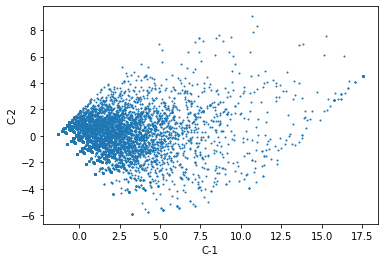

In [16]:
components.plot.scatter("C-1", 
                        "C-2",
                        s=1
                       );

Now we cluster the two components instead of all the input variables:

In [17]:
seed(12345)
estimator = KMeans(n_clusters = 5)
estimator.fit(components)
k5_pca = pandas.Series(estimator.labels_,
                       index=components.index
                      )

We can compare how both solutions relate to each other (or not):

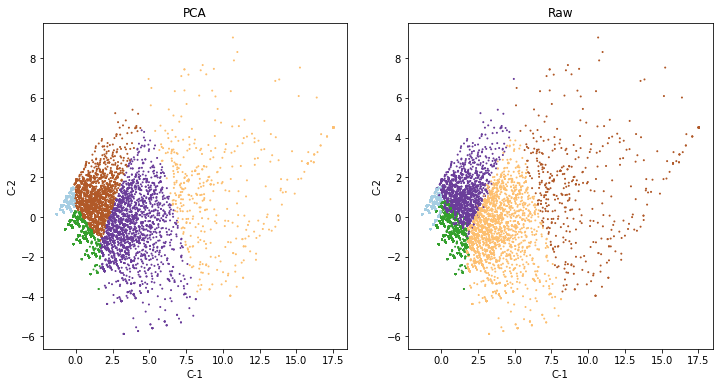

In [18]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
components.assign(labels=k5_pca)\
          .plot.scatter("C-1", 
                        "C-2",
                        c="labels",
                        s=1,
                        cmap="Paired",
                        colorbar=False,
                        ax=ax
                       )
ax.set_title("PCA")

ax = axs[1]
components.assign(labels=k5_raw)\
          .plot.scatter("C-1", 
                        "C-2",
                        c="labels",
                        s=1,
                        cmap="Paired",
                        colorbar=False,
                        ax=ax
                       )
ax.set_title("Raw")

plt.show()

Actually pretty similar (which is good!). But remember that our original input was expressed in the same units anyway, so it makes sense.

---

**EXERCISE**: Add a third plot to the figure above visualising the labels with the range-scaled transformation.

---

### Explore the classification

- Quality of clustering ([Calinski and Harabasz score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), the ratio of between over within dispersion)

In [19]:
chs_raw = calinski_harabasz_score(db[review_areas],
                                  k5_raw
                                 )

In [20]:
chs_std = calinski_harabasz_score(db[review_areas],
                                  k5_std
                                 )

In [21]:
chs_pca = calinski_harabasz_score(db[review_areas],
                                  k5_pca
                                 )

In [22]:
pandas.Series({"Raw": chs_raw,
               "Standardised": chs_std,
               "PCA": chs_pca,
              })

Raw             16481.669537
Standardised    14732.094496
PCA             16549.690854
dtype: float64

The higher, the better, so either the original or PCA.

We can also use this to "optimise" (or at least explore its behaviour) the number of clusters. Let's pick the original input as the scores suggest are more desirable:

In [23]:
%%time
seed(12345)

chss = {}
for i in [2, 5, 10, 15, 20, 30]:
    estimator = KMeans(n_clusters=i)
    estimator.fit(components)
    chs = calinski_harabasz_score(db[review_areas], 
                                  estimator.labels_
                                 )
    chss[i] = chs
chss = pandas.Series(chss)

CPU times: user 21.6 s, sys: 5.96 s, total: 27.6 s
Wall time: 18.4 s


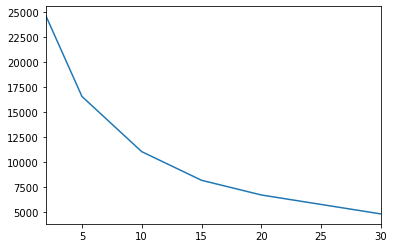

In [24]:
chss.plot.line()

5 clusters? 🤔

- Quality of clustering ([silhouette scores](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient))

In [25]:
%%time
sil_raw = silhouette_score(db[review_areas], 
                           k5_raw,
                           metric="euclidean"
                          )

CPU times: user 1min, sys: 17.8 s, total: 1min 18s
Wall time: 1min 10s


In [26]:
%%time
sil_std = silhouette_score(db[review_areas], 
                           k5_std,
                           metric="euclidean"
                          )

CPU times: user 53.4 s, sys: 15.9 s, total: 1min 9s
Wall time: 1min 2s


In [27]:
%%time
sil_pca = silhouette_score(db[review_areas], 
                           k5_pca,
                           metric="euclidean"
                          )

CPU times: user 59.5 s, sys: 15.6 s, total: 1min 15s
Wall time: 1min 8s


In [28]:
pandas.Series({"Raw": sil_raw,
               "Standardised": sil_std,
               "PCA": sil_pca,
              })

Raw             0.327701
Standardised    0.305185
PCA             0.313708
dtype: float64

For a graphical analysis of silhouette scores, see here:

> [https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)


---

**EXERCISE** Compare silhouette scores across our three original approaches for three and 20 clusters

---

- Characterise

Internally:

In [29]:
g = db[review_areas]\
      .groupby(k5_pca)

In [30]:
g.size()\
 .sort_values()

2      444
3     3046
4     8594
1    15499
0    22697
dtype: int64

In [31]:
g.mean()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,9.934485,10.000000,9.924924,9.950037,9.825924,9.701855
1,9.740435,8.717337,9.890832,9.930125,9.756178,9.356281
2,5.006757,4.788288,5.682432,5.772523,7.245495,4.558559
3,8.225213,6.746881,8.807945,8.853250,9.069599,7.658897
4,9.052944,8.929486,9.053293,9.148243,9.347335,8.697696


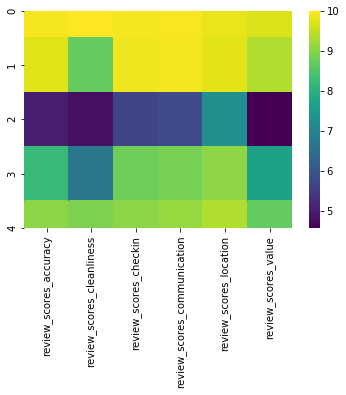

In [32]:
sns.heatmap(g.mean(), cmap='viridis');

To explore the _distribution_ of the values inside each cluster, rather than their mean, we can use the fancy `FaceGrid` approach:

In [33]:
tidy_db = db[review_areas]\
            .stack()\
            .reset_index()\
            .rename(columns={"level_1": "Var",
                             "level_0": "ID",
                             0: "Value"
                            })\
            .join(pandas.DataFrame({"Label": k5_pca}),
                  on="ID")
tidy_db.head()

,ID,Var,Value,Label
0,0,review_scores_accuracy,10.0,0
1,0,review_scores_cleanliness,10.0,0
2,0,review_scores_checkin,10.0,0
3,0,review_scores_communication,10.0,0
4,0,review_scores_location,10.0,0


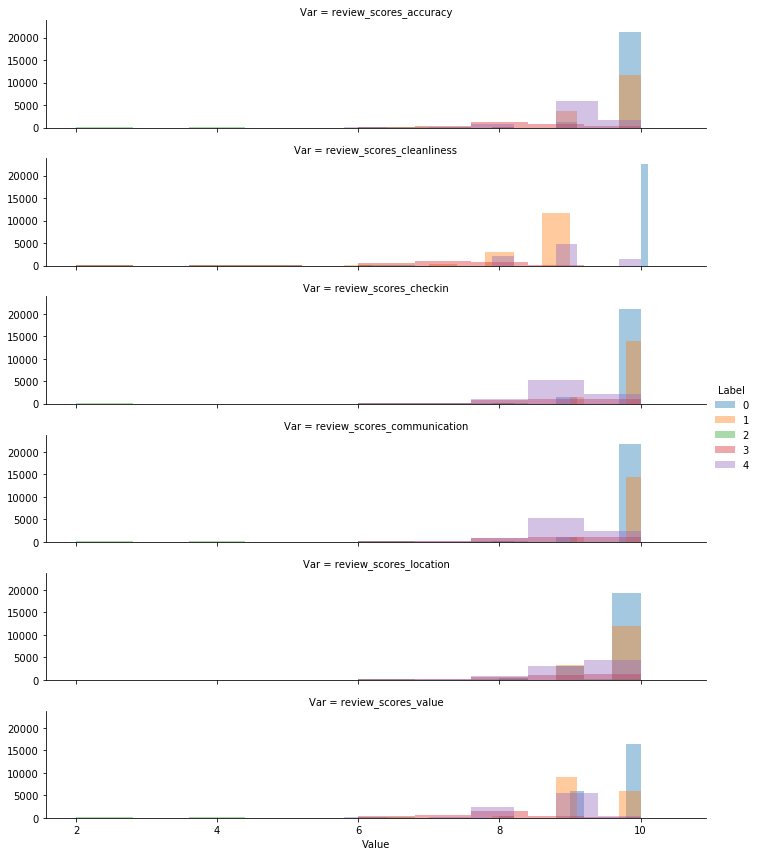

In [34]:
g = sns.FacetGrid(tidy_db,
                  row="Var",
                  hue="Label",
                  height=2,
                  aspect=5
                 )
g.map(sns.distplot, 
      "Value", 
      hist=True,
      bins=10,
      kde=False,
      rug=False
     )
g.add_legend();

---

Externally:

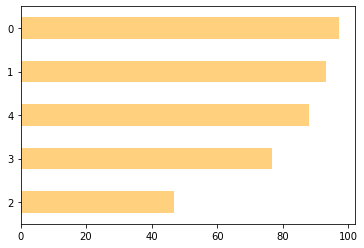

In [35]:
# Cross with review_scores_rating
db.groupby(k5_pca)\
  ["review_scores_rating"]\
  .mean()\
  .sort_values()\
  .plot.barh(color="orange",
             alpha=0.5
            );

---

**EXERCISE** Can you cross the clustering results with property prices? Create:

- A bar plot with the average price by cluster
- A plot with the distribution (KDE/hist) of prices within cluster

---

Before we move on, let's also save the labels of the results:

In [36]:
pandas.DataFrame({"k5_pca": k5_pca})\
      .to_parquet("../data/k5_pca.parquet")